# Punctuation restoration

The sequence tagging with BERT-like models is quite common among researchers nowdays
+ For example, the following research https://www.researchgate.net/publication/348618580_Automatic_punctuation_restoration_with_BERT_models (WordPiece + BERT uncased) suggests tagging words with labes `EMPTY`, `PERIOD`, `COMMA` etc. when they are followed by a punctuation symbol or not. The minor downside of suggested approach is that they use full-fledged dictionary, which may me memory-consuming. 
+ The overlapping sliding window is suggested to deal with sentences of the size exceeding input length. Due to overelap, for the same pieces we may get several predictions. The mean of them will be taken.

First of all, in my research I'd like to concentrate on correcting commas in a sentence, so I may limit my output data to "COMMA" and "EMP" for now

1. To train the model from scratch, we have to perform conversion of BPE encoded data to a form, in which our objective would be to predict, wheither a token is followed by a comma/period.

What else can be added:
- Not use lower() on corpus?
- Proper sentence splitting
- Cleanse messy punctuation from original corpus - as long as I aim this model to work in my telegram assistant, I can expect myself not using strange symbols.

## Step 1: common preparation of textual data

Yttm will behave nicely with text with commas, separated by space from both sides. This approach misses some information, like common word endings that are followed by a comma, yet it may be simplier to implement.

**Important**: this shall be done for every training case. At the evaluation step text shall not contain any commas

In [1]:
import youtokentome as yttm
import pandas as pd
import numpy as np
import re

In [2]:
data = pd.read_parquet("text_corpus.parquet")

In [3]:
corpus = [text.replace(",", " ,") for text in data.text]

## Step 2: creating encoder
For such modified text data bpe encoder shall be trained separately, of course.

In [6]:
TOTAL_WORDS = 30000
BPE_MODEL_PATH = "bpe.yttm"
def create_bpe_tokenizer_from_scratch(corpus, train_data_path="yttm_train_data.txt"):
    with open(train_data_path, "w") as _file:
        _file.writelines(corpus)
    # Training model
    # (data, model, vocab_size, coverage, n_threads=-1, pad_id=0, unk_id=1, bos_id=2, eos_id=3)
    return yttm.BPE.train(data=train_data_path, vocab_size=TOTAL_WORDS, model=BPE_MODEL_PATH)

In [7]:
bpe = create_bpe_tokenizer_from_scratch(" \n ".join(corpus))

In [8]:
COMMA = bpe.encode(" ,")[0] # COMMA token shall be fixed after each re-training

In [9]:
print(' '.join(bpe.vocab())[:600])

<PAD> <UNK> <BOS> <EOS> ▁ о е и а н т с р в л к д п м у я ы з г б , ь й ч . х ж ' ц ю ш щ - ф С Р П э М В К А И О Н Д Ф Г Б Т « » У Е Л Ш ( ) Э ъ З — Ч Я Х Ц : Ю Ъ Ж – ? ” Й ё “   ! ; … Щ / Ы [ ] Ь > < ‒ ­ + * Ё ‘ ​ # • ̆ ‎ ` @ ‚ ’ _ \ & ️ · = ▁п ст ▁, ▁в ен ▁с ов ра ре ▁н ▁о но то ко ро ни ▁и ▁по ли го те за ль ет ри ны ▁на ▁д ка ени ла та ер на ци ми ств ▁ч ки да ▁б ▁' ти ть ▁за ▁со ▁м ле сс ▁у ви ▁не ру ся ди ▁ко ва ова ▁пре ло об де ста ▁что не ▁ра ско ▁П ▁Р ▁а ▁про ▁об ▁С сти ▁- ▁от ▁э ▁М ▁во ма по во ▁г тель мо ения ля ово ▁В че зи ▁при сси ▁ре ции ду ры щи ем ей ных сто ски ной ▁К ча ▁к


## Step 3: comma encoding algorithm

Now as we have a way to create a numerical representation of our textual data, we have to process it in a way to 
1. Remove all commas (our model shall not know where they are originally, just try to predict)
2. Save information about commas in a way we will be able to calculate loss between a model's prediction and actual data.

In short, our algorithm will be the following:
1. At the position of each word followed by a comma we will put label 1
2. The following comma token will be stripped out
3. At the end, lengthes of encoded sentence and label list shall be equal.

In [10]:
def encode_commas(sent):
    # for-loopish version can be optimized
    result = []
    for idx, token in enumerate(sent):
        if idx == len(sent) - 1:
            # no comma checking for last token
            result.append(0)
        else:
            if token == COMMA:
                continue
            elif sent[idx+1] == COMMA:
                result.append(1)
            else:
                result.append(0)
    assert sum(result) > 0, "Sentence MUST contain at least 1 comma"
    return result

## Step 4: creating train data


1. Encode a sentence
2. Encode commas
3. Strip commas from encoded sentence
4. Ensure lengthes are equal

In [13]:
from razdel import sentenize

In [24]:
# we dont need sents without commas
corpus_of_sents_with_commas = [ sent.strip() 
                               for text in corpus 
                               for sent in [s.text for s in sentenize(text)]
                               if "," in sent ]

In [25]:
corpus_of_sents_with_commas[4]

'Процесс создания взрывных устройств на основе данного вещества является опасным (как пишут СМИ , трипероксид ацетона террористы нередко называют «мать Сатаны»).'

In [26]:
encoded_corpus = []
tags = []
for idx, sent in enumerate(corpus_of_sents_with_commas):
    encoded_sentence = bpe.encode(sent)
    if not COMMA in encoded_sentence:
        continue
    if encoded_sentence[0] == COMMA: # issue of period separation
        continue
    taglist = encode_commas(encoded_sentence)
    encoded_sentence = list(filter(lambda x: x != COMMA, encoded_sentence))
    es_len = len(encoded_sentence)
    tl_len = len(taglist)
    if es_len != tl_len:
        print(f"Lengthes do not match at {idx}: sentence has {es_len} and taglist has {tl_len}")
        continue
    encoded_corpus.append(encoded_sentence)
    tags.append(taglist)

Lengthes do not match at 46016: sentence has 29 and taglist has 30
Lengthes do not match at 102000: sentence has 34 and taglist has 35
Lengthes do not match at 108587: sentence has 17 and taglist has 18
Lengthes do not match at 192253: sentence has 11 and taglist has 12


In [27]:
len(encoded_corpus)

223567

In [28]:
assert len(tags) == len(encoded_corpus)

## Step 5: creating model

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [31]:
EMBEDDING_DIM = 24
HIDDEN_DIM    = 24
VOCAB_SIZE    = TOTAL_WORDS
TAGSET_SIZE   = 2

In [47]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)
#         self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
#         self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [48]:
# weighted loss function
zerocount = sum([len(a) - sum(a) for a in tags])
onecount = sum([sum(a) for a in tags])

class_divs = torch.tensor([zerocount, onecount], dtype=float)
norm = torch.norm(class_divs, p=2, dim=0).detach()

class_divs = class_divs.div(norm.expand_as(class_divs))
class_weights = torch.ones(2)

class_weights /= class_divs

print(class_weights.detach())

tensor([ 1.0041, 11.1331])


In [49]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.01)

In [50]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

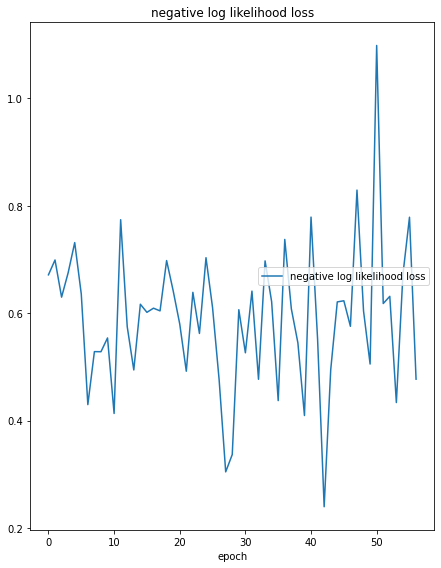

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.240, max:    1.098, cur:    0.477)


In [ ]:
for epoch in range(10): 
    for i, (text, taglist) in enumerate(zip(encoded_corpus, tags)):
        
        model.zero_grad()
        text = torch.tensor(text)
        taglist = torch.tensor(taglist)
#         print(text, labels)
#         break
        tag_scores = model(text)

        loss = loss_function(tag_scores, taglist)
        loss.backward()
        optimizer.step()
        
        
#         print(loss)
#         print(type(loss.detach().numpy()))
#         break
        if i % 1000 == 0:
            l = loss.detach().numpy()
            liveplot.update({'negative log likelihood loss': l})
            liveplot.draw()
            
            
#         if i == 15000:
#             break

## Step 6: evaluation and inverse transformation

Now when we have a model predicting commas for us, it would be useful to inject those predictions right into our sentence.

idea: assume the pre-existing commas are correct, and fill in nly missing ones.

In [290]:
def fill_in_commas(text):
    # ensure text has no commas
    text = text.replace(",", "")
    # ensure text accidentaly has no spaces in a row
    text = re.sub("\s{2,}", " ", text)
    # encode text by bpe
    encoded_text = bpe.encode(text)
    # get predicted labels
    with torch.no_grad():
        predicted_tags = model.predict_tags(torch.tensor(encoded_text))
    # inject commas
    result = []
    for token, label in zip(encoded_text, predicted_tags):
        result.append(token)
        if label:
            result.append(COMMA)
    result = bpe.decode(result)[0]
    # return normal spacing
    result = result.replace(" ,", ",")
    return result
    

In [291]:
fill_in_commas("я не знаю что это такое однако могу предположить что что-то плохое")

'я не знаю, что это такое однако могу предположить, что что-то плохое'

In [295]:
fill_in_commas("ой, ну это да, надо убираться больше а ещё почухать его")

'ой ну это да надо убираться больше а ещё почухать его'

## Saving the model

In [293]:
torch.save(model.state_dict(), 'lstm_tagger.pt')
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

model.load_state_dict(torch.load('lstm_tagger.pt'))
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(30000, 32)
  (lstm): LSTM(32, 32)
  (hidden2tag): Linear(in_features=32, out_features=2, bias=True)
)